In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection as model_selection

In [2]:
data = pd.read_csv('master_model_data.csv', index_col=0)

In [3]:
data.head()

,DESYNPUF_ID,BENE_SEX_IDENT_CD,BENE_RACE_CD,SP_STATE_CODE,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,...,#Rx_mm,$Rx_mm,carrier_pmt_mm,carrier_number_claims_mm,office_visits_mm,office_visits_pmt_mm,CLM_ID_mm,TOTAL_PAYMENT_PERID_mm,total_pmt_mm,age_bucket
0,00000B48BCF4AD29,1,5,10,2,1,2,2,2,2,...,0.166667,7.000000,541.000000,4.700000,1.300000,181.333333,0.333333,90.000000,3338.0,4
1,0000525AB30E4DEF,1,1,31,2,2,2,2,2,2,...,3.966667,213.666667,432.000000,3.733333,0.833333,105.666667,0.966667,179.333333,1225.0,4
2,00009C897C3D8372,0,1,7,2,1,2,2,2,2,...,1.733333,138.000000,107.333333,1.600000,0.200000,7.333333,0.433333,85.333333,1534.0,3
3,0001168CE43BE51B,1,1,6,2,2,2,2,2,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3
4,0002E494BC87CE10,0,2,5,2,2,2,2,2,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4


In [4]:
working_data = data

In [8]:
working_data = working_data.drop_duplicates(['DESYNPUF_ID'])
working_data.drop('DESYNPUF_ID',axis=1, inplace=True)

In [14]:
#Normalize features

import sklearn.preprocessing as sk

labels = working_data.drop('Y', axis=1).columns
index = working_data.index

norm = pd.DataFrame(sk.scale(working_data.drop('Y', axis=1)), columns = labels, index = index)
norm['Y'] =  working_data['Y']

In [10]:
#Split dataset into testing and training

test, train = model_selection.train_test_split(norm)

train_Y = train.pop('Y')
train_X = train

test_Y = test.pop('Y')
test_X = test


In [11]:

#Making a decision tree and AUC to check feature importances
from sklearn.tree import DecisionTreeClassifier

#build a decision tree with max_depth = 20 using entropy
Y = train_Y
X = train_X

dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20)
dt.fit(X, Y)

#Now use built in feature importance attribute to get MI of each feature and Y
feature_mi = dt.feature_importances_
#Add features and their importances to a dictionary
feature_mi_dict = dict(zip(X.columns.values, feature_mi))

In [12]:
#define a function to print ROC curves. 
#It should take in only arrays/lists of predictions and outcomes
from sklearn.metrics import roc_curve, auc

def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #Student input code here
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

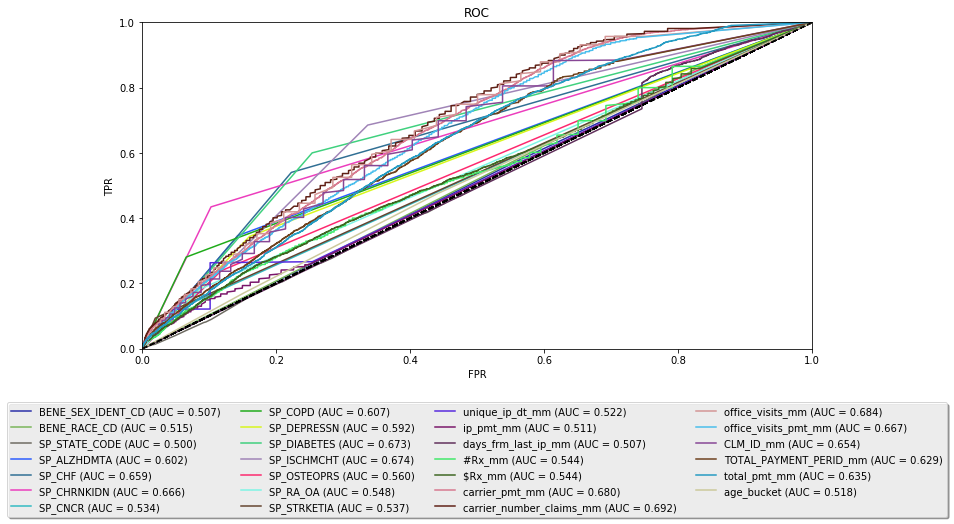

In [13]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC


#Student put code here
feature_auc_dict = {}
for col in X.columns:
    feature_auc_dict[col] = plotUnivariateROC(X[col], Y, col)


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

#### Conclusion

The ROC of individual features reavealed the importance of nonlinear relationships of the target variable with such features as number of carrier claims (69% AUC), number of office visits (68% AUC), carrier payments (68%), ischemic heart disease, diabetes, kidney disease.